In [17]:
import argparse
import sys
import os
import random
import numpy as np
import torch
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sys.path.append("/workspace")

from src.dataloader.dataloader import CocoDataset, get_dataloader
from src.utils.engine import evaluate
from src.model.faster_rcnn import get_model_instance_segmentation
from src.utils.logger import init_log
from configs.default import get_cfg_from_file

In [5]:

init_log("global", "info")
SEED = 42
CHECKPOINT_ROOT = os.path.join(
    "/workspace/checkpoints",
    datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")
)


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

class Config():
    def __init__(self):
        self.cfg = "/workspace/configs/training/default.yaml"

if __name__ == "__main__":
    args = Config()
    cfg = get_cfg_from_file(args.cfg)
    os.makedirs(CHECKPOINT_ROOT, exist_ok=True)

    train_dataset = CocoDataset(
        img_dir=cfg.DATASET.TRAIN.IMAGE,
        ann_file=cfg.DATASET.TRAIN.ANNOTATION,
    )

    val_dataset = CocoDataset(
        img_dir=cfg.DATASET.VAL.IMAGE,
        ann_file=cfg.DATASET.VAL.ANNOTATION
    )

    train_dataloader = get_dataloader(
        train_dataset,
        batch_size=cfg.TRAIN.BATCH_SIZE
    )

    val_dataloader = get_dataloader(
        val_dataset,
        batch_size=cfg.TRAIN.BATCH_SIZE
    )

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
train_iter = iter(train_dataloader)

In [23]:
images, target = train_iter.next()

In [24]:
img_np = images[0].to("cpu").numpy().transpose(1, 2, 0)
target_np = target[0]["boxes"].to("cpu").numpy()

In [25]:
sigma = 2
img_np_viz = np.clip((img_np + sigma)/(2*sigma), 0, 1)

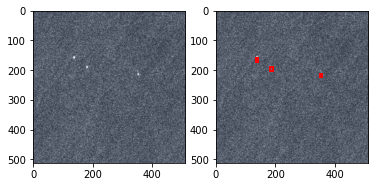

In [26]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(img_np_viz)
axes[1].imshow(img_np_viz)
for box in target_np:
    center_x = (box[0] + box[2]) / 2
    center_y = (box[1] + box[3]) / 2
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (center_x, center_y),
        width,
        height,
        linewidth=2,
        edgecolor="red",
        fill=False
    )
    axes[1].add_patch(rect)